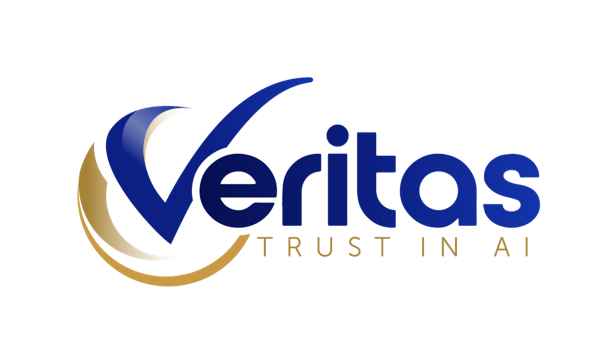

# Veritas Diagnosis Tool Demo : Credit Scoring Classification Model 
    
<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a credit scoring model and use daignosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness assessment report.
</p>    
<p>    
    Credit scoring model is a binary classification model for prediction customer loan repayment. <br/>
    Steps to perform: <br/>
    1. Loading Data and Model <br/>  
    2. Diagnose Model Fairness in <b>Diagnosis tool</b> <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.1 compute performance and fairness metrics <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 compute trade off analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3 compute feature importance analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.4 save results in json artifact <br/>
</p>

# 1. Loading Data and Model

## Environment Setup

To run this example notebook, use the commands below in your terminal:

```python
# create a conda environment
$ conda create --name veritas-env python=3.8
# activate conda environment
$ conda activate veritas-env
# install Veritas demo notebook dependencies
$ pip install veritastool==1.0.2 imbalanced-learn notebook==6.4.12 lightgbm==3.3.1
# [OPTIONAL] install mlflow dependencies 
$ pip install mlflow pycaret SQLAcademy
# create notebook kernel connected with the conda environment
$ python -m ipykernel install --user --name veritas-env --display-name "veritas-env"
```

[OPTIONAL] To create an mlflow  server, run the following in the terminal:

```python
$ mlflow server --backend-store-uri sqlite:///$HOME/mlflow.db --default-artifact-root $HOME/artifacts --port 8100
```

In [ ]:
# select the jupyter notebook kernel and check that you have the packages installed:
import sys
!{sys.executable} -m pip list | grep -E 'veritas|mlflow'

In [ ]:
[mlflow_uri] = !echo http://read-only-$CDSW_ENGINE_ID.$CDSW_DOMAIN

print(mlflow_uri)

In [ ]:
# making veritas available in search path (for running demo notebook on veritas github repo, not the PyPi)
sys.path.insert(0, '../../')

In [ ]:
import numpy as np
import pandas as pd
import pickle
import sys  
from pathlib import Path
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
import os
import random
%load_ext autoreload
%autoreload 2

## Loading Data 

Dataset used is generated from : [Kaggle hosted UCI credit card dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)

In [ ]:
pth = os.path.abspath('.')

#Load Credit Scoring Test Data
file = os.path.join(pth, 'data',"credit_score_dict.pickle") 
input_file = open(file, "rb")
cs = pickle.load(input_file)
selector = random.randrange(2000, 22000, 2000)
print(selector)

#Reduce into two classes
cs["X_train"]['MARRIAGE'] = cs["X_train"]['MARRIAGE'].replace([0, 3],1)
cs["X_test"]['MARRIAGE'] = cs["X_test"]['MARRIAGE'].replace([0, 3],1)
#Model Contariner Parameters
y_true = np.array(cs["y_test"])[:selector]
y_pred = np.array(cs["y_pred"])[:selector]
y_train = np.array(cs["y_train"])[:selector]
p_var = ['SEX', 'MARRIAGE']
p_grp = {'SEX': [1], 'MARRIAGE':[1]}
x_train = cs["X_train"][:selector]
x_test = cs["X_test"][:selector]
model_name = "credit scoring"
model_type = "credit"
y_prob = cs["y_prob"][:selector]

#sample feature_imp
sample = os.path.join(pth, 'data',"sample.csv")
feature_imp = pd.read_csv(sample)

## Data Exploration

In [ ]:
print("No of rows: {} \nNo. of columns: {}".format(x_train.shape[0],x_train.shape[1]))
x_train.head()

Class imbalance

In [ ]:
counts = pd.Series(y_train).value_counts()
print("count of neg class: {} \ncount of pos class: {}".format(counts[0],counts[1]))

Differently scaled columns

In [ ]:
x_train.describe().astype(int)

## Building Model 
### (Optional. User can resume from section 2)

In [ ]:
#Upsampling
categorical_features = [i for i, col in enumerate(x_train.columns) if str(x_train[col].dtype).startswith('int')]
smote = SMOTENC(random_state=0, categorical_features=categorical_features)
X_upsml, y_upsml = smote.fit_resample(x_train, y_train)

#Scaling
scaling = StandardScaler()
X_upsml_scld = scaling.fit_transform(X_upsml)

#Model fitting
log_reg = LogisticRegression(C=0.1,random_state=0,  max_iter=4000)
log_reg.fit(X_upsml_scld, y_upsml)

In [ ]:
x_test_scaled = scaling.transform(x_test)
test_preds = log_reg.predict(x_test_scaled)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true,test_preds),3)))

In [ ]:
#Using finetuned Threshold
best_th = 0.43

test_probs = log_reg.predict_proba(x_test_scaled)[:, 1] 
test_preds = np.where(test_probs > best_th, 1, 0)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true,test_preds),3)))

# 2. Diagnose Model Fairness

## Import Veritas Diagnosis Library

Veritas Library use case object creation includes two step. In the first step, Model_Container object is created with generic machine learning inputs. In the second step, use case object is created with Model_Container object and use case specific inputs. Currently, CustomerMarketing and CreditScoring objects are available. CreditScoring is showcased in this notebook.

In [ ]:
from veritastool.model.modelwrapper import ModelWrapper
from veritastool.model.model_container import ModelContainer
from veritastool.fairness.credit_scoring import CreditScoring

## Create model object using Model Wrapper

In [ ]:
class LRwrapper(ModelWrapper):

    def __init__(self, model_obj):
        self.model_obj = model_obj
       

    def fit(self, X, y):
    
        #Upsampling
        categorical_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'int8']
        smote = SMOTENC(random_state=0, categorical_features=categorical_features)
        X, y = smote.fit_resample(X, y)

        #Scaling
        scaling = StandardScaler()
        X = scaling.fit_transform(X)

   
        self.model_obj.fit(X, y)
  
    
    def predict(self, x_test, best_th = 0.43):
        
        test_probs = self.model_obj.predict_proba(x_test)[:, 1] 
        
        #Using finetuned Threshold
        test_preds = np.where(test_probs > best_th, 1, 0)
        return test_preds

In [ ]:
log_reg_untrained = LogisticRegression(C=0.1)
model_obj = LRwrapper(log_reg_untrained)

## Initializing Veritas Diagnosis Library

In [ ]:
#Create Model Container 
container = ModelContainer(y_true,  p_var, p_grp, model_type, model_name,  y_pred, \
                           y_prob, y_train, feature_imp = feature_imp, x_train=x_train, x_test=x_test, \
                           model_object=model_obj )


<h5 align="center">Table 1: Model Container parameters   </h5>

| Var Name    | Category       |Sub-category   | Description   |  Value        |  Compulsory   |
| :---        |    :----:      |   :----:      |          ---: |          ---: |        ---: |
| y_true      | data           | testing       | test set labels| array([0, 1, 1, ..., 1])   |Yes|
| y_pred      | data           | testing       | test set predicted labels | array([0, 1, 1, ..., 1])   |Yes|
| y_prob      | data           | testing       | test set predicted probabilities | array([0.56, 0.33, 0.11, ..., 0.98])|No|
| x_test      | data           | testing       | test set features | -      |No|
| y_train     | data           | training      | train set labels      | array([0, 1, 1, ..., 1])   |No|
| x_train     | data           | training      | train set features |-      |No|
| p_var       | protected vars |    -          | list of protected vars| [ 'SEX', 'MARRIAGE' ]      |Yes|
| p_grp       | protected vars |    -          | list of priveleged groups| { 'SEX': [ 1 ] , 'MARRIAGE': [ 1 ] }   |Yes|
| model_obj   | model          |    -          | model to assess| -      |No|
| model_type  | model          |    -          | type of model | 'credit'    |Yes|
| model_name  | model          |    -          | name of model | 'credit scoring'   |No|
| feature_imp | model          |    -          | list of feature imps for model| -   |No|


In [ ]:
#Create Use Case Object
cre_sco_obj= CreditScoring(model_params = [container], fair_threshold = 80, fair_concern = "inclusive", \
                           fair_priority = "harm", fair_impact = "normal", 
                           mlflow_uri="http://localhost:8100", mlflow_user='optional_username',
                          mlflow_desc='optional run description'
                          )


<h5 align="center">Table 2: Credit Scoring parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_metric_name| metric name |primary fairness metric | "auto" or any of supported ones <br/> like "equal_opportunity" |No|
| perf_metric_name      | metric name |primary performance metric |"balanced_acc"   |No|
| fair_concern | fair_metric selection | most concerned cohort |"eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection|top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection |impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_threshold | fairness metric thresolding |threshold used for assessment|actual value [0,1] or p% rule (1,100]|Yes|


## Starting Fairness diagnosis

In [ ]:
%matplotlib inline
cre_sco_obj.evaluate(visualize=True, output=True) 

In [ ]:
cre_sco_obj.tradeoff()

<h5 align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Table 3: Use of protected variable in model</h5>

|Fairness|Performace|Suggestion|
|---	|---	|---	|
|Worse  |Worse	|Include|
|Better|Better|Exclude|
|Worse|Better|Examine Further|
|Better|Worse|Examine Further|

In [ ]:
cre_sco_obj.feature_importance()

In [ ]:
cre_sco_obj.compile()